In [1]:
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 3.1MB 28.8MB/s 
     |████████████████████████████████| 501kB 44.5MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Let's try training a simple 2 layers RNN with different learning rates.

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 204ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 194.8099 - mae: 195.2815
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 193.5298 - mae: 194.0093
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 191.9202 - mae: 192.4067
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 190.0269 - mae: 190.5204
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 187.8482 - mae: 188.3494
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 185.3580 - mae: 185.8679
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 182.5147 - mae: 183.0343
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 179.2627 - mae: 179.7937
Epoch 10/100
8/8 [==============================] - 0s 25ms/step - loss: 175.5317 - mae: 176.0756
Epoch 11/100
8/8 [==========

[1e-08, 0.0001, 0, 30]

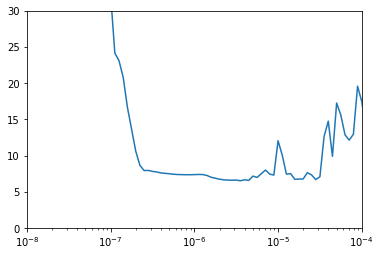

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## 5*10e-5 seems to be a reasonable learning rate, hence it gets chosen.

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 208ms/step - loss: 80.8704 - mae: 83.5782
Epoch 2/400
8/8 [==============================] - 0s 24ms/step - loss: 23.3276 - mae: 24.1570
Epoch 3/400
8/8 [==============================] - 0s 25ms/step - loss: 17.8614 - mae: 18.4302
Epoch 4/400
8/8 [==============================] - 0s 24ms/step - loss: 11.9517 - mae: 12.5089
Epoch 5/400
8/8 [==============================] - 0s 23ms/step - loss: 9.9229 - mae: 10.1368
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 13.7531 - mae: 14.3888
Epoch 7/400
8/8 [==============================] - 0s 26ms/step - loss: 9.6444 - mae: 10.0865
Epoch 8/400
8/8 [==============================] - 0s 24ms/step - loss: 11.9429 - mae: 12.3598
Epoch 9/400
8/8 [==============================] - 0s 24ms/step - loss: 13.2042 - mae: 13.7624
Epoch 10/400
8/8 [==============================] - 0s 24ms/step - loss: 9.5772 - mae: 10.0502
Epoch 11/400
8/8 [==============================] -

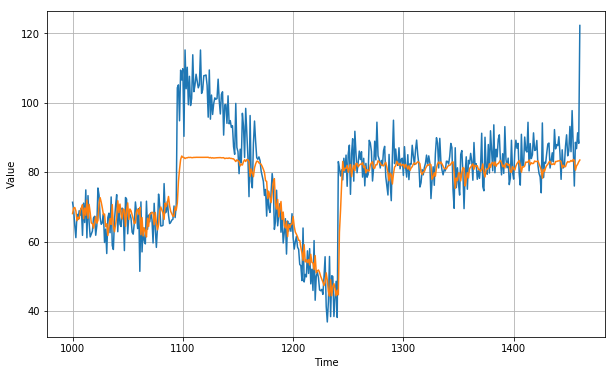

In [17]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.4141674

<Figure size 432x288 with 0 Axes>

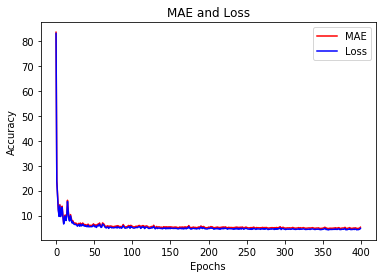

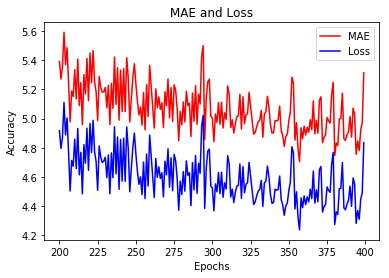

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Seems to work fine!